CODE INI DIJALANKAN DI KAGGLE NOTEBOOK


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/reptiles-and-amphibians-image-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/reptiles-and-amphibians-image-dataset/Chameleon/chameleon-3051481__340.jpg
/kaggle/input/reptiles-and-amphibians-image-dataset/Chameleon/chameleon-2157836__340.jpg
/kaggle/input/reptiles-and-amphibians-image-dataset/Chameleon/chameleon-1874514__340.jpg
/kaggle/input/reptiles-and-amphibians-image-dataset/Chameleon/chameleon-6079780__340.jpg
/kaggle/input/reptiles-and-amphibians-image-dataset/Chameleon/africa-1170042__340.jpg
/kaggle/input/reptiles-and-amphibians-image-dataset/Chameleon/chameleon-1686952__340.jpg
/kaggle/input/reptiles-and-amphibians-image-dataset/Chameleon/chameleon-63148__340.jpg
/kaggle/input/reptiles-and-amphibians-image-dataset/Chameleon/chameleon-4216101__340.jpg
/kaggle/input/reptiles-and-amphibians-image-dataset/Chameleon/lizards-3158450__340.jpg
/kaggle/input/reptiles-and-amphibians-image-dataset/Chameleon/chameleon-4757635__340.jpg
/kaggle/input/reptiles-and-amphibians-image-dataset/Chameleon/sleeping-chameleon-202417__340.jpg
/kaggle/input/reptil

*Dataset yang digunakan merupakan kumpulan gambar hewan dari dua kelas utama: reptil dan amfibi. DaDataset terdiri dari gambar-gambar spesies reptil dan amfibi yang dikelompokkan dalam 10 kelas, yaitu: Salamander, Turtle/Tortoise, Frog, Lizard, Toad, Crocodile/Alligator, Iguana, Snake, Chameleon, dan Gecko.
Setiap folder berisi citra-citra hewan sesuai kelasnya, yang digunakan sebagai data latih untuk membangun model klasifikasi berbasis ciri visual.*

# **📌 1. Import Library**




In [3]:
import os
import numpy as np
import pandas as pd
import cv2
from skimage.io import imread
from skimage.transform import resize as sk_resize
from skimage.feature import hog
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# **📌 2. Load Dataset, Tentukan Label, Penentuan Ukuran Resize**

*Baris kode dibawah ini menetapkan lokasi dataset, daftar nama hewan, dan ukuran standar gambar agar model bisa mengenali jenis hewan dari gambarnya.*

In [4]:
dataset_path = "/kaggle/input/reptiles-and-amphibians-image-dataset"
classes = ['Salamander', 'Turtle_Tortoise', 'Frog', 'Lizard', 'Toad',
           'Crocodile_Alligator', 'Iguana', 'Snake', 'Chameleon', 'Gecko']
IMG_SIZE = (96, 96)


*Ukuran citra ditetapkan sebesar 96x96 piksel. Pemilihan ukuran ini mempertimbangkan keseimbangan antara detail visual yang cukup untuk ekstraksi fitur dan efisiensi komputasi agar pemrosesan dapat dilakukan dengan cepat tanpa kehilangan informasi penting.*

# **📌 3. Ekstraksi Fitur**

In [5]:
def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features, _ = hog(gray, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      orientations=12, block_norm="L2-Hys", visualize=True)
    return features

def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_hu_moments(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    moments = cv2.moments(gray)
    hu = cv2.HuMoments(moments).flatten()
    return hu


Dalam proyek ini digunakan tiga metode ekstraksi fitur utama, yaitu Histogram of Oriented Gradients (HOG), Histogram warna, dan Hu Moments.

1. HOG (Histogram of Oriented Gradients) dipilih karena efektif dalam menangkap informasi bentuk dan kontur objek pada citra, yang sangat penting untuk membedakan struktur tubuh reptil dan amfibi.

2. Histogram warna digunakan untuk merepresentasikan distribusi warna secara global dalam citra. Warna merupakan fitur yang penting dalam klasifikasi, terutama saat jenis hewan memiliki corak warna khas.

3. Hu Moments dipilih karena dapat mengenali bentuk berdasarkan momen geometri citra yang invarian terhadap skala, rotasi, dan translasi. Ini membantu sistem mengenali objek meskipun posisi atau ukurannya berubah.

Kombinasi ketiga metode ini memungkinkan model untuk menangkap informasi bentuk, warna, dan struktur dengan lebih komprehensif sehingga meningkatkan akurasi dalam klasifikasi gambar reptil dan amfibi.

In [6]:
flat_data = []
target = []
images = []

for category in classes:
    path = os.path.join(dataset_path, category)
    for file in os.listdir(path):
        try:
            img_path = os.path.join(path, file)
            img = imread(img_path)
            img = sk_resize(img, IMG_SIZE)
            img = (img * 255).astype(np.uint8)
            if img.shape[-1] == 4:
                img = img[:, :, :3]  # remove alpha if exists
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # ekstraksi fitur
            hog_feat = extract_hog_features(img_rgb)
            color_feat = extract_color_histogram(img_rgb)
            hu_feat = extract_hu_moments(img_rgb)
            features = np.hstack([hog_feat, color_feat, hu_feat])

            flat_data.append(features)
            target.append(classes.index(category))
            images.append(img_rgb)

        except Exception as e:
            print(f"❌ Error processing {file}: {e}")

flat_data = np.array(flat_data)
target = np.array(target)

df = pd.DataFrame(flat_data)
df['Target'] = [classes[i] for i in target]

print("Jumlah sampel:", df.shape[0])
print("Jumlah fitur per sampel:", df.shape[1] - 1)
df.head()


Jumlah sampel: 6045
Jumlah fitur per sampel: 6327


,0,1,2,3,4,5,6,7,8,9,...,6318,6319,6320,6321,6322,6323,6324,6325,6326,Target
0,0.032569,0.000000,0.000000,0.121685,0.232763,0.153403,0.254692,0.168189,0.140317,0.083687,...,0.011884,0.000000,0.001133,1.334385e-08,1.437816e-11,1.247373e-13,-9.997872e-26,2.278506e-19,1.338280e-25,Salamander
1,0.144592,0.021902,0.073492,0.036695,0.178097,0.272600,0.272600,0.085480,0.171013,0.079003,...,0.000000,0.232841,0.001692,4.991669e-09,2.055703e-11,3.364713e-12,8.897565e-24,2.078728e-16,-2.653130e-23,Salamander
2,0.205540,0.009753,0.000000,0.000000,0.014629,0.008992,0.181189,0.035318,0.079993,0.238996,...,0.004045,0.011325,0.001272,5.840682e-09,1.827876e-12,5.696812e-12,-8.331479e-24,2.164911e-16,-1.638684e-23,Salamander
3,0.140171,0.068994,0.090973,0.154050,0.080684,0.244977,0.244977,0.050884,0.089637,0.056057,...,0.000417,0.000000,0.001714,7.601729e-09,2.661991e-11,9.212929e-12,1.136121e-22,3.787822e-16,8.892917e-23,Salamander
4,0.279283,0.036114,0.034258,0.045041,0.139906,0.156784,0.279283,0.083701,0.030747,0.186997,...,0.010199,0.076834,0.001413,1.640453e-08,4.299669e-12,6.561010e-11,8.411236e-22,4.399105e-15,7.119482e-22,Salamander


*Program membaca semua gambar dari folder dataset berdasarkan jenis hewannya. Gambar diubah ukurannya menjadi 96x96 piksel agar seragam, lalu diproses untuk diambil ciri-cirinya (fitur) menggunakan tiga metode: bentuk (HOG), warna (histogram), dan pola bentuk geometri (Hu Moments). Semua fitur tersebut digabung dan disimpan dalam array flat_data, sedangkan label jenis hewan disimpan dalam target. Gambar asli juga disimpan untuk visualisasi. Data akhir dikumpulkan dalam bentuk tabel (DataFrame) agar bisa digunakan untuk melatih model klasifikasi.*

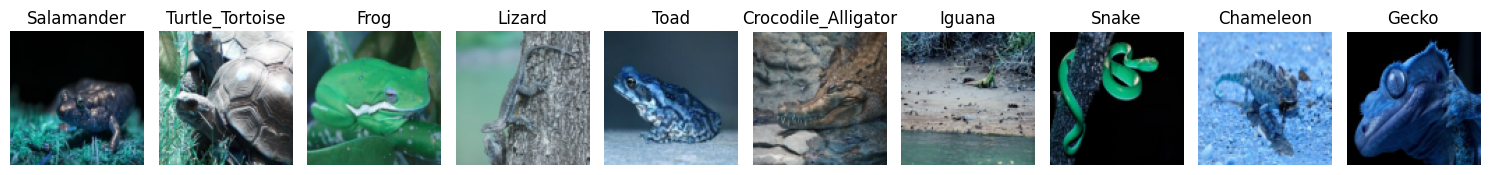

In [7]:
fig, axes = plt.subplots(1, len(classes), figsize=(15, 4))

# Fix untuk 1 subplot
if len(classes) == 1:
    axes = [axes]
else:
    axes = axes.ravel()

for ax, i in zip(axes, range(len(classes))):
    class_name = classes[i]
    idxs = [j for j, t in enumerate(target) if t == i]
    if idxs:
        chosen_idx = np.random.choice(idxs)
        img = images[chosen_idx]
        if img is not None:
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(class_name)
        else:
            ax.set_visible(False)
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()


*Program akan membuat sejumlah gambar sebanyak jumlah kelas (jenis hewan), lalu memilih satu gambar secara acak dari masing-masing kelas. Gambar-gambar ini ditampilkan dalam satu baris secara berdampingan, dan di atas masing-masing gambar tertulis nama hewan tersebut, seperti "Toad", "Lizard", atau "Crocodile_Alligator". Ini berguna untuk memastikan bahwa gambar-gambar tersebut memang sesuai dengan labelnya dan proses pembacaan datanya berjalan dengan baik.*

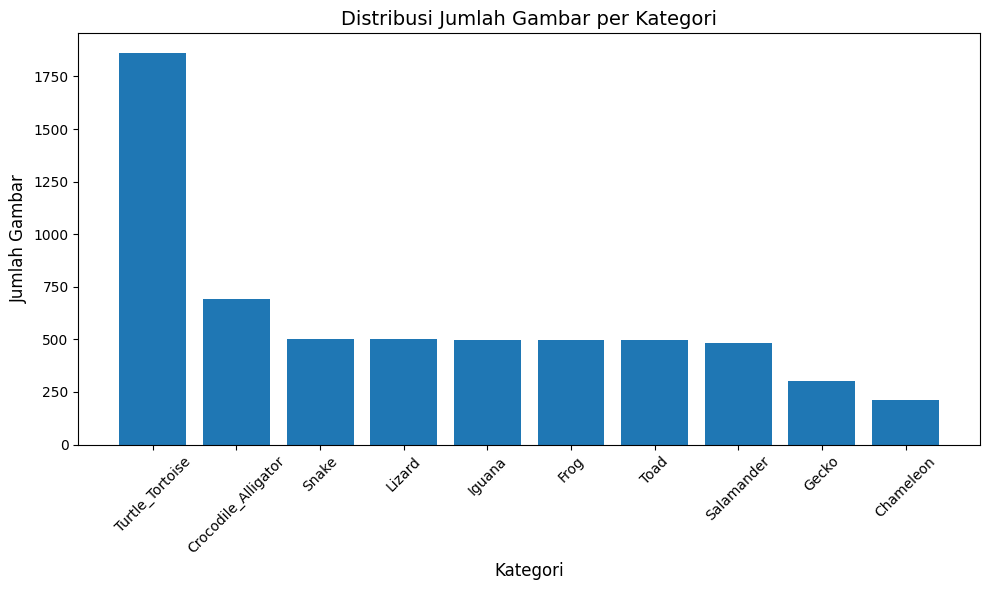

In [8]:

# Menghitung jumlah gambar per kategori
category_counts = df['Target'].value_counts()

# Membuat bar chart
plt.figure(figsize=(10,6))
plt.bar(category_counts.index, category_counts.values)

# Judul dan label
plt.title("Distribusi Jumlah Gambar per Kategori", fontsize=14)
plt.xlabel("Kategori", fontsize=12)
plt.ylabel("Jumlah Gambar", fontsize=12)
plt.xticks(rotation=45)  # Supaya label gak tabrakan kalau panjang
plt.tight_layout()  # Biar grafik gak kepotong

# Tampilkan grafik
plt.show()

*membuat grafik batang (bar chart) yang menunjukkan jumlah gambar untuk setiap kategori hewan. Dengan mengambil data dari kolom Target pada DataFrame, kita bisa menghitung sebaran jumlah gambar per kelas.*

# **📌 4. Augmentasi Data**

In [9]:
def augment_image(image):
    img_flip = cv2.flip(image, 1)
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 10, 1)  # rotasi tetap
    img_rot = cv2.warpAffine(image, M, (cols, rows))
    img_bright = cv2.convertScaleAbs(image, alpha=1.2, beta=20)
    img_contrast = cv2.equalizeHist(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
    return [image, img_flip, img_rot, img_bright, cv2.cvtColor(img_contrast, cv2.COLOR_GRAY2RGB)]

Fungsi augment_image(image) digunakan untuk menambah variasi data pelatihan melalui augmentasi citra. Proses ini meliputi:
1. Flip horizontal: Mencerminkan gambar untuk mengenali objek dari sudut pandang berbeda.
2. Rotasi 10 derajat: Menambahkan variasi orientasi objek.
3. Peningkatan kecerahan: Mengatasi variasi pencahayaan.
4. Peningkatan kontras: Membuat detail objek lebih jelas.

Dengan menambahkan citra hasil augmentasi, model dapat menjadi lebih robust terhadap variasi kondisi visual di dunia nyata.

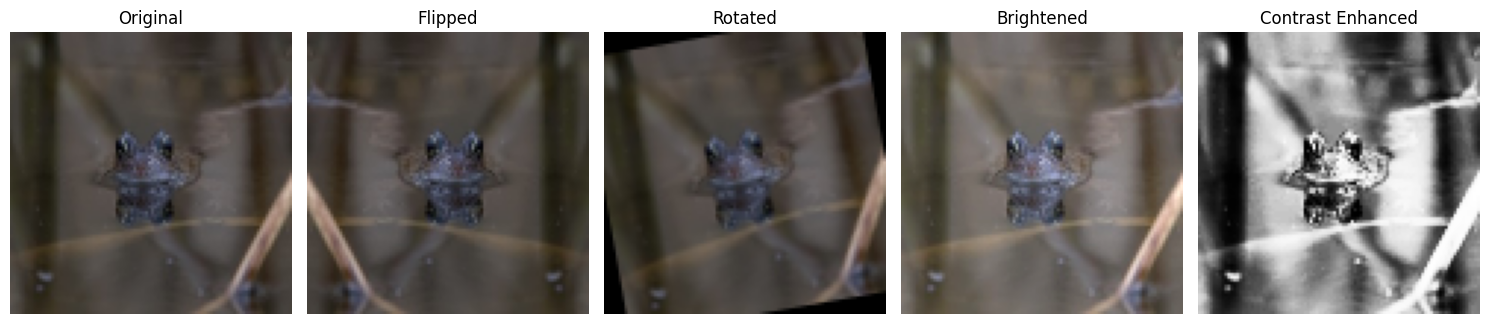

In [10]:
import random
import matplotlib.pyplot as plt

# === PILIH 1 GAMBAR DARI SALAH SATU KELAS ===
sample_class = "Frog"
class_path = os.path.join(dataset_path, sample_class)
sample_file = random.choice(os.listdir(class_path))  # pilih file secara acak
img_path = os.path.join(class_path, sample_file)

# === BACA GAMBAR ===
img = cv2.imread(img_path)
if img is not None:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (96, 96))

    # === AUGMENTASI ===
    augmented_images = augment_image(img)
    titles = ["Original", "Flipped", "Rotated", "Brightened", "Contrast Enhanced"]

    # === PLOTTING ===
    fig, axes = plt.subplots(1, len(augmented_images), figsize=(15, 5))
    for i, aug_img in enumerate(augmented_images):
        axes[i].imshow(aug_img)
        axes[i].axis("off")
        axes[i].set_title(titles[i])

    plt.tight_layout()
    plt.show()
else:
    print(f"Gagal membaca gambar: {img_path}")

*Menjalankan fungsi augmentasi pada satu gambar yang dipilih secara acak dari folder kelas "Frog". Gambar tersebut dibaca, diubah ukurannya menjadi 96x96 piksel, lalu diproses menggunakan fungsi augmentasi yang sudah dibuat sebelumnya. Hasilnya berupa lima versi gambar: asli, dibalik, diputar, lebih terang, dan ditingkatkan kontrasnya. Kelima gambar ini kemudian ditampilkan berdampingan dalam satu baris untuk melihat perbedaan hasil augmentasi secara visual. Ini membantu memastikan bahwa fungsi augmentasi bekerja dengan baik.*

In [ ]:
def load_images_with_features(base_path, classes):
    X, Y = [], []
    for label, class_name in enumerate(classes):
        class_path = os.path.join(base_path, class_name)
        for filename in os.listdir(class_path):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (96, 96))
                
                img_aug = augment_image(img)[0]  
                hog = extract_hog_features(img_aug)
                color = extract_color_histogram(img_aug)
                hu = extract_hu_moments(img_aug)
                features = np.hstack([hog, color, hu])

                X.append(features)
                Y.append(label)
    return np.array(X), np.array(Y)


*Fungsi ini membaca semua gambar dari dataset, melakukan augmentasi ringan, dan mengekstrak tiga jenis fitur (bentuk, warna, geometri) lalu menggabungkannya jadi satu. Hasilnya disimpan dalam X (fitur) dan Y (label).*

# **📌 5. Pembagian Data dan Pelatihan Model**

Model yang digunakan adalah KNN (K-Nearest Neighbors) berdasarkan fitur yang telah diekstraksi.

In [12]:
X, Y = load_images_with_features(dataset_path, classes)
print(f"Total samples: {len(Y)}")
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")

Total samples: 6044
Train size: 4835, Test size: 1209


*Data dibagi menjadi 80% untuk pelatihan dan 20% untuk pengujian agar model bisa dilatih dan diuji dengan data berbeda. Stratifikasi digunakan agar sebaran kelas tetap seimbang.*

In [13]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

*Fitur-fitur dalam data distandarkan ke skala 0–1 agar model seperti KNN bisa bekerja lebih optimal dan adil dalam mengukur jarak antar data.*

In [14]:
# Reduksi dimensi menggunakan PCA (bisa disesuaikan jumlah komponennya)
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA selesai. Jumlah fitur awal:", X.shape[1], "| Setelah PCA:", X_train_pca.shape[1])

PCA selesai. Jumlah fitur awal: 6327 | Setelah PCA: 1050


*Fitur yang sudah dinormalisasi dikurangi jumlah dimensinya menggunakan PCA (Principal Component Analysis), agar lebih ringkas tapi tetap mempertahankan 90% informasi. Ini mempercepat pelatihan model tanpa banyak kehilangan akurasi.*

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17],
    "metric": ["euclidean", "manhattan", "minkowski", "chebyshev"],
    "weights": ["uniform", "distance"]
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski',
                                    'chebyshev'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

*Menggunakan GridSearchCV untuk mencari kombinasi terbaik dari parameter KNN seperti jumlah tetangga (n_neighbors), jenis metrik jarak, dan bobot. Model diuji dengan cross-validation 5-fold untuk akurasi terbaik.*

In [16]:
best_k = grid_search.best_params_["n_neighbors"]
best_metric = grid_search.best_params_["metric"]
best_weights = grid_search.best_params_["weights"]
print(f"Best K: {best_k}, Best Metric: {best_metric}, Best Weights: {best_weights}")

Best K: 17, Best Metric: chebyshev, Best Weights: uniform


*Setelah grid search selesai, program mencetak parameter terbaik yang ditemukan—berapa jumlah tetangga terbaik, metrik jarak yang paling cocok, dan jenis bobot yang optimal.*

In [17]:
knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric, weights=best_weights)
knn.fit(X_train_pca, y_train)

KNeighborsClassifier(metric='chebyshev', n_neighbors=17)

*Model KNN dibuat lagi dengan parameter terbaik hasil Grid Search. Setelah itu, model dilatih (fit) menggunakan data pelatihan yang sudah diproses PCA.*

In [18]:
y_pred = knn.predict(X_test_pca)

*Model yang sudah dilatih digunakan untuk memprediksi label dari data uji (X_test_pca). Hasil prediksi disimpan di y_pred.*

In [19]:
class_mapping = {
    'Salamander': 'Amphibia',
    'Frog': 'Amphibia',
    'Toad': 'Amphibia',
    
    'Turtle_Tortoise': 'Reptilia',
    'Lizard': 'Reptilia',
    'Crocodile_Alligator': 'Reptilia',
    'Iguana': 'Reptilia',
    'Snake': 'Reptilia',
    'Chameleon': 'Reptilia',
    'Gecko': 'Reptilia'
}


*Mendefinisikan kamus (class_mapping) untuk mengelompokkan jenis hewan ke dalam dua kelompok besar: Amphibia dan Reptilia. Ini berguna jika nanti ingin evaluasi atau visualisasi berdasarkan kelompok utama.*

# **📌 6. Visualisasi Prediksi**

Beberapa hasil prediksi dari data uji divisualisasikan bersama label prediksi dan label aslinya, untuk melihat kemampuan klasifikasi secara visual.

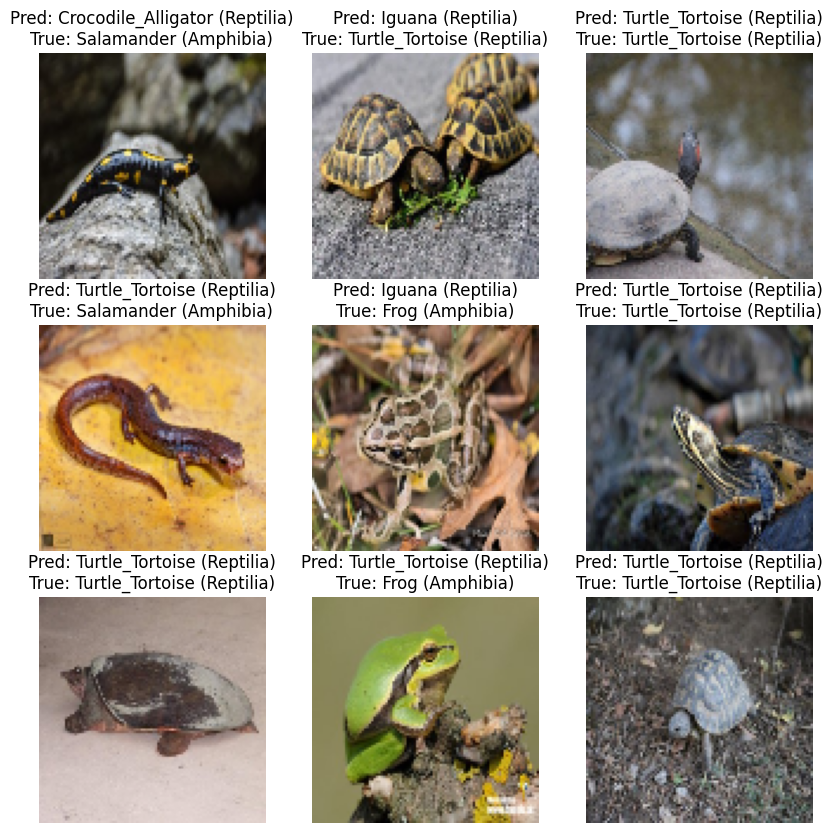

In [20]:
def load_image_from_dataset(index, base_path, classes):
    all_images = []  # List untuk menyimpan semua path gambar
    image_index_map = {}  # Dictionary to map image index to path

    current_index = 0  # Initialize current index

    for label, class_name in enumerate(classes):
        class_path = os.path.join(base_path, class_name)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            all_images.append(img_path)  # Tambahkan path ke list
            image_index_map[current_index] = img_path  # Add mapping
            current_index += 1

    # Load gambar berdasarkan index dari list all_images
    img_path = image_index_map.get(index) # Get image path using index
    if img_path is None:
        return None # If index not found return None

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (96, 96))
    return img

# Split data and get indices
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, Y, np.arange(len(X)), test_size=0.2, random_state=42
)

# Visualisasi beberapa prediksi (acak)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)

    # Pilih indeks acak dari indices_test
    random_index = random.choice(indices_test)

    # Mendapatkan indeks gambar asli dari data uji menggunakan random_index
    original_index = random_index

    # Memuat gambar asli dari dataset
    img = load_image_from_dataset(original_index, dataset_path, classes)

    if img is not None:
        plt.imshow(img)

        # Mendapatkan prediksi dan label asli untuk gambar yang dipilih secara acak
        prediction_index = np.where(indices_test == random_index)[0][0]

        pred_label = classes[y_pred[prediction_index]]
        true_label = classes[y_test[prediction_index]]

        pred_category = class_mapping[pred_label]
        true_category = class_mapping[true_label]

        plt.title(f'Pred: {pred_label} ({pred_category})\nTrue: {true_label} ({true_category})')
        plt.axis('off')
    else:
        plt.text(0.5, 0.5, "Image not found", ha="center", va="center")

plt.show()

*Kode ini menampilkan hasil prediksi model dengan membandingkan label asli dan label prediksi dari data uji. Fungsi `load_image_from_dataset()` digunakan untuk memuat ulang gambar berdasarkan indeks global. Setiap gambar ditampilkan bersama label prediksi dan label sebenarnya, sehingga kita bisa secara visual menilai akurasi model dan mendeteksi kesalahan klasifikasi. Visualisasi ini juga membantu memastikan bahwa model mengenali gambar dengan baik meskipun belum pernah melihatnya saat pelatihan.*

# **📌 7. Evaluasi Model**

In [21]:
# Decode label prediksi & label asli ke nama kelas
y_pred_labels = [classes[label] for label in y_pred]
y_test_labels = [classes[label] for label in y_test]

# Mapping kelas ke kategori biologi
y_pred_category = [class_mapping[label] for label in y_pred_labels]
y_test_category = [class_mapping[label] for label in y_test_labels]

# Buat label biner: Reptilia = 0, Amphibia = 1
y_test_binary = [int(label == "Amphibia") for label in y_test_category]
y_pred_binary = [int(label == "Amphibia") for label in y_pred_category]

# Tampilkan laporan klasifikasi
print("\n 1. Classification Report per Kelas Spesifik:\n")
print(classification_report(y_test, y_pred, target_names=classes))

print("\n 2. Classification Report (Amphibia vs Reptilia):\n")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Reptilia", "Amphibia"]))


 1. Classification Report per Kelas Spesifik:

                     precision    recall  f1-score   support

         Salamander       0.12      0.06      0.08       119
    Turtle_Tortoise       0.31      0.71      0.43       365
               Frog       0.00      0.00      0.00        94
             Lizard       0.17      0.05      0.08        99
               Toad       0.12      0.05      0.07        96
Crocodile_Alligator       0.12      0.18      0.14       131
             Iguana       0.06      0.01      0.02        98
              Snake       0.06      0.01      0.02        99
          Chameleon       0.00      0.00      0.00        48
              Gecko       0.14      0.02      0.03        60

           accuracy                           0.25      1209
          macro avg       0.11      0.11      0.09      1209
       weighted avg       0.16      0.25      0.17      1209


 2. Classification Report (Amphibia vs Reptilia):

              precision    recall  f1-score

Kode ini mengevaluasi performa model dalam dua level klasifikasi:

1. **Klasifikasi Spesifik per Spesies:**  
   Menampilkan *precision*, *recall*, dan *f1-score* untuk tiap kelas seperti Salamander, Turtle, Frog, dll. Hasil menunjukkan bahwa model lebih akurat pada kelas dengan jumlah data lebih besar, seperti *Turtle_Tortoise*, tapi lemah pada kelas minoritas seperti *Frog* dan *Chameleon*.

2. **Klasifikasi Biner: Amphibia vs Reptilia:**  
   Label kelas dikelompokkan menjadi dua kategori biologis. Hasil menunjukkan akurasi tinggi pada *Reptilia* (91% recall), tapi rendah untuk *Amphibia* (11% recall), menandakan model belum seimbang dalam membedakan kedua kelompok utama ini.

Evaluasi ini membantu mengidentifikasi ketimpangan klasifikasi dan potensi perbaikan pada distribusi data atau arsitektur model.

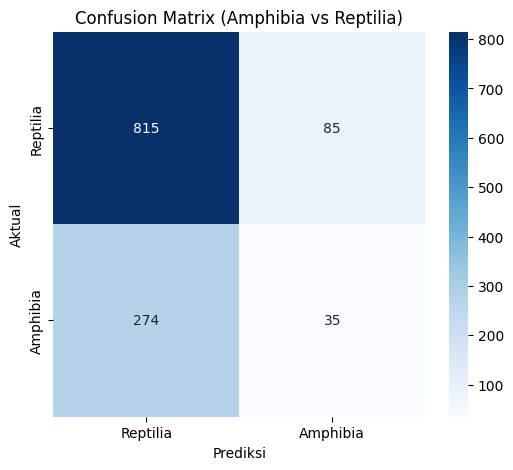

In [22]:
# Confusion matrix untuk kategori biologi
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Reptilia", "Amphibia"],
            yticklabels=["Reptilia", "Amphibia"])

plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix (Amphibia vs Reptilia)")
plt.show()

*Menampilkan (confusion matrix) dalam bentuk heatmap untuk dua kategori utama. Grafik ini membantu melihat jumlah prediksi benar dan salah antara Reptilia dan Amphibia, sehingga mempermudah evaluasi performa klasifikasi biner.*

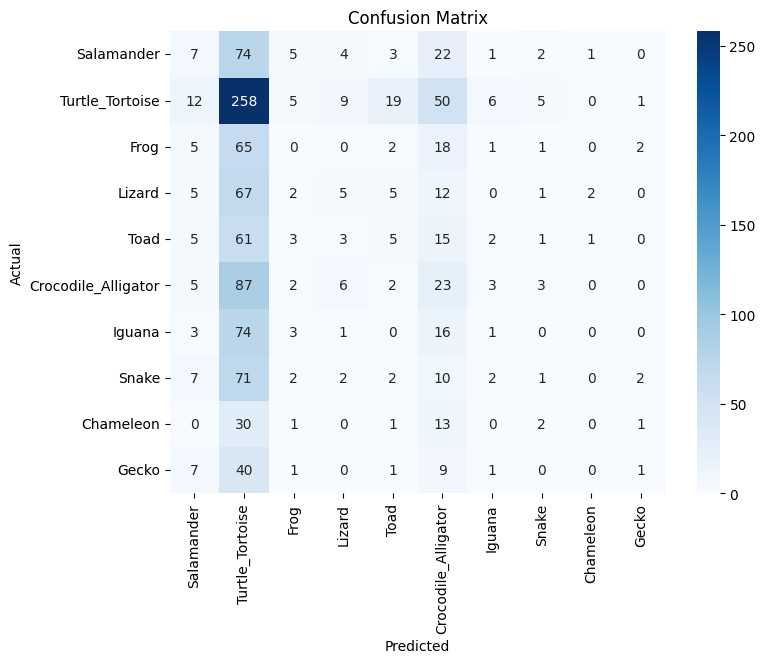

In [23]:
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

*Menampilkan confusion matrix yang lebih rinci untuk semua 10 jenis hewan secara individual. Heatmap ini menunjukkan seberapa sering model salah mengira satu hewan sebagai hewan lain.*

In [24]:
print("Jumlah fitur waktu training:", X_train.shape[1])


Jumlah fitur waktu training: 6327


In [25]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 36.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 92.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.5 MB/s eta 0:00:00


In [26]:
def augment_image(image):
    img_flip = cv2.flip(image, 1)
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), np.random.randint(-15, 15), 1)
    img_rot = cv2.warpAffine(image, M, (cols, rows))
    img_bright = cv2.convertScaleAbs(image, alpha=1.2, beta=20)
    img_contrast = cv2.equalizeHist(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
    return [image, img_flip, img_rot, img_bright, cv2.cvtColor(img_contrast, cv2.COLOR_GRAY2RGB)]
    
def extract_all_features(img):
    img = cv2.resize(img, (96, 96))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hog = extract_hog_features(img)
    color = extract_color_histogram(img)
    hu = extract_hu_moments(img)
    return np.hstack([hog, color, hu])


In [27]:
!pip install ipywidgets


# **📌 8. Gradio Interface**

*Antarmuka berbasis web disiapkan menggunakan Gradio untuk memudahkan pengguna mengunggah gambar dan langsung melihat hasil klasifikasinya.Prosesnya meliputi ekstraksi fitur, normalisasi, reduksi dimensi dengan PCA, dan prediksi menggunakan KNN. Hasil ditampilkan dalam bentuk tabel.*

In [39]:
import gradio as gr
import numpy as np
import cv2
import pandas as pd

def predict_animal_category(image):
    # Pra-pemrosesan gambar
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (96, 96))

    # Ekstraksi fitur
    hog_features = extract_hog_features(img)
    color_features = extract_color_histogram(img)
    shape_features = extract_hu_moments(img)
    features = np.hstack([hog_features, color_features, shape_features])

    # Normalisasi dan reduksi dimensi
    features_scaled = scaler.transform([features])
    features_pca = pca.transform(features_scaled)

    # Prediksi
    probabilities = knn.predict_proba(features_pca)[0]
    prediction_label = np.argmax(probabilities)
    prediction_class = classes[prediction_label]
    prediction_category = class_mapping[prediction_class]

    # Output DataFrame 2 kolom
    result_df = pd.DataFrame({
        "Jenis Hewan": [prediction_class],
        "Kategori": [prediction_category]
    })
    return result_df

# Gradio interface
iface = gr.Interface(
    fn=predict_animal_category,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Dataframe(headers=["Jenis Hewan", "Kategori"], row_count=1),
    title="Prediksi Kategori Hewan (Reptil vs Amfibi)",
    description="Unggah gambar hewan untuk memprediksi apakah termasuk Amphibia atau Reptilia."
)

iface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7864
* Running on public URL: https://e09739ea2a5768ab29.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **📌 9. Hasil Klasifikasi**

Antarmuka berbasis web disiapkan menggunakan Gradio untuk memudahkan pengguna mengunggah gambar dan langsung melihat hasil klasifikasinya. Salah satu hasil klasifikasi yang didapat

![Hasil Klasifikasi](https://raw.githubusercontent.com/Aiurskiesyx/VC/main/Hasil%20Klasifikasi.png)


Gambar menunjukkan antarmuka aplikasi klasifikasi hewan berbasis web menggunakan Gradio. Pengguna mengunggah gambar seekor Salamander, dan sistem berhasil mengklasifikasikannya dengan benar sebagai:

*Jenis Hewan: Salamander*

*Kategori Biologi: Amphibia*

Sistem ini memanfaatkan model machine learning yang telah dilatih sebelumnya, dan menggunakan pipeline preprocessing serta fitur seperti HOG, Hu Moments, dan histogram warna untuk mengenali spesies hewan berdasarkan citra.